# Assignment 16

>[Assignment 16](#folderId=15ajXxXKSOQRXfo4h9HDkwJ7rp-GhJhaX&updateTitle=true&scrollTo=xrlMavQOr2rB)

>>>[Imports and Installations](#folderId=15ajXxXKSOQRXfo4h9HDkwJ7rp-GhJhaX&updateTitle=true&scrollTo=0CD1unLcyW4l)

>>>[Question 1](#folderId=15ajXxXKSOQRXfo4h9HDkwJ7rp-GhJhaX&updateTitle=true&scrollTo=jAY2_KhF5t7N)

>>>>[Section A](#folderId=15ajXxXKSOQRXfo4h9HDkwJ7rp-GhJhaX&updateTitle=true&scrollTo=ODe6Uw8V6HBn)

>>>>[Section B](#folderId=15ajXxXKSOQRXfo4h9HDkwJ7rp-GhJhaX&updateTitle=true&scrollTo=XM_SAsNM7GkT)

>>>>[Sections C and D](#folderId=15ajXxXKSOQRXfo4h9HDkwJ7rp-GhJhaX&updateTitle=true&scrollTo=Kr-vISj_9jAi)

>>[Question 2](#folderId=15ajXxXKSOQRXfo4h9HDkwJ7rp-GhJhaX&updateTitle=true&scrollTo=pii3AK21MSOa)

>>>>[Understanding the Flow-Control RNN](#folderId=15ajXxXKSOQRXfo4h9HDkwJ7rp-GhJhaX&updateTitle=true&scrollTo=_NQ-aqlGNvZ1)

>>>>[Design Motivation](#folderId=15ajXxXKSOQRXfo4h9HDkwJ7rp-GhJhaX&updateTitle=true&scrollTo=A1Ovx1nLmZt1)



### Imports and Installations

In [1]:
# from IPython.utils import capture

# with capture.capture_output() as captured:
#     !pip install torchtext==0.17.2
#     !pip install -U datasets

In [ ]:
!pip install torchtext==0.17.2
!pip install -U datasets

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch import nn
import datasets as ds
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from datasets import load_dataset
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def get_device():
    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"
    # Check for MPS
    elif torch.backends.mps.is_available():
        return "mps"
    # Default to CPU
    else:
        return "cpu"

### Question 1

#### Section A

Load and Process the SST-2 Dataset:

In [ ]:
dataset = load_dataset("glue", "sst2")
train_set = dataset["train"][:1500]
validation_set = dataset["validation"][:500]
test_set = dataset["test"]

In [6]:
# Tokenize and convert to tensor
def tokenize_and_convert(sentences, vocab, max_len=50):
    tokenized = [torch.tensor([vocab[token] for token in sentence.split()]) for sentence in sentences]
    padded = torch.zeros(len(sentences), max_len, dtype=torch.long)
    lengths = torch.zeros(len(sentences), dtype=torch.long)
    for i, tokens in enumerate(tokenized):
        length = min(len(tokens), max_len)
        padded[i, :length] = tokens[:length]
        lengths[i] = length
    return padded, lengths

In [7]:
vocab = build_vocab_from_iterator(
    map(str.split, train_set["sentence"]), specials=["<unk>"], min_freq=5
)
vocab.set_default_index(vocab["<unk>"])

In [8]:
train_sentences, train_lengths = tokenize_and_convert(train_set["sentence"], vocab)
train_labels = torch.tensor(train_set["label"], dtype=torch.long)

In [9]:
# Custom Dataset class
class SST2Dataset(Dataset):
    def __init__(self, data, vocab):
        self.sentences = [str(s).split() for s in data["sentence"]]
        self.labels = data["label"]
        self.vocab = vocab

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = [self.vocab[token] for token in self.sentences[idx]]
        label = self.labels[idx]
        return torch.tensor(sentence, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Collate function for padding
def collate_fn(batch):
    sentences, labels = zip(*batch)
    lengths = [len(s) for s in sentences]
    padded_sentences = nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded_sentences, torch.tensor(labels), torch.tensor(lengths)

In [10]:
# Create data loader
train_dataset = SST2Dataset(train_set, vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

#### Section B

We now define the RNN classifier:

---

**Model Overview:**

- The model uses `nn.RNNCell` for manual unrolling for control over gradient truncation.
- The `forward` method processes sequences token by token, applies a mask for padding, and detaches the hidden state at `T - t` to limit BPTT.
- Gradient norms are saved via a hook on `h_t`, and a plotting function visualizes them.
- the hook only for time steps where gradients are tracked (i.e., after `T - t`), or ensure gradients are collected correctly by checking the hook's behavior.
- The detachment occurs at `i == max_len - self.t` for limiting BPTT to the last `t` time steps. We verify that `max_len` is correctly derived from `lengths.max().item()` and that `self.t` is appropriately set.


In [11]:
# Define RNNClassifier
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, num_classes: int, t: int = 10):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn_cell = nn.RNNCell(embed_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.grads = []
        self.t = t

    def forward(self, x: torch.Tensor, lengths: torch.Tensor):
        """
        x: Tensor of shape (batch_size, seq_len)
        lengths: Tensor of shape (batch_size) with sequence lengths
        Returns: Logits of shape (batch_size, num_classes)
        """
        self.grads = []  # Reset gradients list
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        h_t = torch.zeros(batch_size, self.rnn_cell.hidden_size, device=x.device)

        max_len = lengths.max().item()
        for i in range(max_len):
            mask = (i < lengths).float().unsqueeze(1)  # (batch_size, 1)
            input_t = embedded[:, i, :]  # (batch_size, embed_dim)
            h_t_next = self.rnn_cell(input_t, h_t)
            h_t = mask * h_t_next + (1 - mask) * h_t  # Preserve h_t for padded tokens

            # Register hook only for steps where gradients are tracked
            if self.training and i >= max(0, max_len - self.t):
                h_t.register_hook(lambda grad: self.grads.append(grad.norm().item()))

            # Detach hidden state at T - t to truncate BPTT
            if i == max_len - self.t - 1 and max_len > self.t:
                h_t = h_t.detach()

        logits = self.fc(h_t)  # (batch_size, num_classes)
        return logits

    def plot_grads(self, seq_len):
        plt.figure(figsize=(8, 6))
        plot_len = len(self.grads)
        if plot_len == 0:
            print("No gradients recorded.")
            return
        # Plot gradients for the last t steps
        plt.plot(range(seq_len - plot_len, seq_len), self.grads, 'o-', label='Gradient Norm')
        plt.axvline(x=max(0, seq_len - self.t), color='r', linestyle='--',
                    label=f'T - t = {max(0, seq_len - self.t)}\n(t={self.t})')
        plt.xlabel("Time Step")
        plt.ylabel("Gradient Norm")
        plt.title(f"Gradient Size for Sequence Length {seq_len}")
        plt.grid(True)
        plt.legend()
        plt.show()


#### Sections C and D

We now train the model:

In [12]:
def train_and_plot(model, sentences, lengths, labels, seq_len, epochs=1):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(sentences, lengths)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

    model.plot_grads(seq_len)

In [13]:
# Model parameters
vocab_size = len(vocab)
embed_dim = 50
hidden_dim = 100
lr = 0.001 # Learning rate
num_classes = 2  # Binary classification
t = 10

In [14]:
device = get_device()

model = RNNClassifier(vocab_size=len(vocab), embed_dim=embed_dim, hidden_dim=hidden_dim, num_classes=num_classes, t=t)
model.to(device)

RNNClassifier(
  (embedding): Embedding(379, 50, padding_idx=0)
  (rnn_cell): RNNCell(50, 100)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [15]:
# Use a small batch for demonstration
batch_size = 32
batch_sentences = train_sentences[:batch_size].to(device)
batch_lengths = train_lengths[:batch_size].to(device)
batch_labels = train_labels[:batch_size].to(device)
max_len = batch_lengths.max().item()

**Expected Output:**

- The plot should show gradient norms for the last `t` time steps (e.g., if `t=10` and `max_len=20`, gradients from time steps 10 to 19).
- A red dashed line at `T - t` (time step 10) indicates where gradients are truncated.
- Gradient norms before `T - t` should be zero (or not plotted), confirming that detachment prevents gradient propagation.

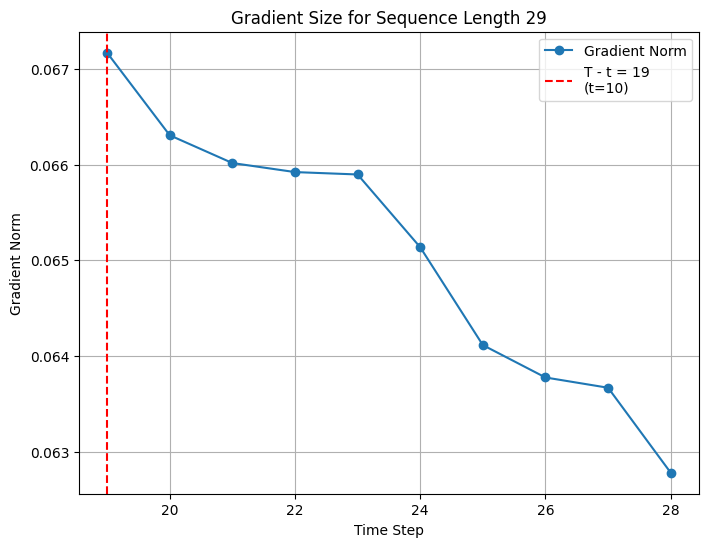

In [16]:
train_and_plot(model, batch_sentences, batch_lengths, batch_labels, max_len)

We can see that it works as expected.

## Question 2

We now implement a flow-control RNN. We need to incorporate a candidate hidden state, a reset mechanism, and train it on a small dataset.


We now load and process SST-2 dataset. We want a small subset for overfitting.

In [17]:
# Load and process SST-2 dataset - we want a small subset for overfitting
dataset = load_dataset("glue", "sst2")
train_set = dataset["train"][:500]
validation_set = dataset["validation"][:100]

# Build vocabulary
vocab = build_vocab_from_iterator(
    map(str.split, train_set["sentence"]), specials=["<unk>", "<pad>"], min_freq=5
)
vocab.set_default_index(vocab["<unk>"])

# Tokenize and convert to tensors
def tokenize_and_convert(sentences, vocab, max_len=50):
    tokenized = [torch.tensor([vocab[token] for token in sentence.split()]) for sentence in sentences]
    padded = torch.zeros(len(sentences), max_len, dtype=torch.long)
    lengths = torch.zeros(len(sentences), dtype=torch.long)
    for i, tokens in enumerate(tokenized):
        length = min(len(tokens), max_len)
        padded[i, :length] = tokens[:length]
        lengths[i] = length
    return padded, lengths

In [18]:
train_sentences, train_lengths = tokenize_and_convert(train_set["sentence"], vocab)
train_labels = torch.tensor(train_set["label"], dtype=torch.long)
val_sentences, val_lengths = tokenize_and_convert(validation_set["sentence"], vocab)
val_labels = torch.tensor(validation_set["label"], dtype=torch.long)

#### Understanding the `Flow-Control RNN`

- **Candidate Hidden State $(\hat{h}_t)$**: Computed as in an Elman RNN, i.e., $\hat{h}_t = \tanh(W_h x_t + U_h h_{t-1} + b_h)$, where $x_t$ is the input token, $h_{t-1}$ is the previous hidden state, and $W_h$, $U_h$, $b_h$ are learnable parameters.
- **Reset State ($R_t$)**: A new hidden state computed solely from the current input token $x_t$, i.e., $R_t = f(W_r x_t + b_r)$, where $f$ is an activation function and $W_r$, $b_r$ are learnable parameters.
- **Next Hidden State**: The hidden state passed to the next time step is $h_t = \hat{h}_t \cdot R_t$, where $\cdot$ denotes element-wise multiplication.
- **Forgetting Mechanism**: The reset state $R_t$ should allow the network to “forget” the hidden state when appropriate, meaning $R_t$ should produce values close to 0 for certain inputs to nullify $\hat{h}_t$.



#### Design Motivation

**Forgetting Mechanism**:

- **Implementation**: The reset state $R_t$ should act as a gate, producing values in $[0, 1]$ (or close to it) to scale the candidate hidden state $\hat{h}_t$. When $R_t \approx 0$, the hidden state $h_t$ is effectively “forgotten” (set close to zero), preventing the previous state from influencing the next time step. When $R_t \approx 1$, the candidate state is passed through unchanged.

- **Justification**: This gating mechanism is inspired by modern RNN architectures like LSTMs and GRUs, where gates (e.g., forget gate in LSTM) control information flow. Allowing the network to learn which inputs trigger forgetting (via $R_t$) gives it flexibility to adapt to the task, rather than hard-coding specific tokens as reset triggers.

**Activation Function for $R_t$**:
- **Choice**: Sigmoid activation ($\sigma(x) = \frac{1}{1 + e^{-x}}$).

**Justifications:**
- The sigmoid function outputs values in $[0, 1]$, which is ideal for a gating mechanism where $R_t$ needs to scale $\hat{h}_t$ between fully retaining ($R_t = 1$) and fully forgetting ($R_t = 0$).
- Sigmoid is differentiable, ensuring gradients can flow during backpropagation.
- Alternatives like ReLU $[0, \infty)$ or tanh ($[-1, 1]$) are less suitable: ReLU can produce unbounded values, complicating the gating interpretation, while tanh allows negative values, which could invert the hidden state's sign, potentially introducing instability or unintended behavior.

**Calculation of $R_t$**:

- **Implementation**: $R_t = \sigma(W_r x_t + b_r)$, where $x_t$ is the embedded input token, $W_r$ is a weight matrix, and $b_r$ is a bias.
- **Justification:**Computing $R_t$ solely from $x_t$ ensures the reset decision is based on the current token, as specified. This allows the network to learn token-specific reset patterns.


In [19]:
# Flow-Control RNN Cell
class FlowControlRNNCell(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super(FlowControlRNNCell, self).__init__()
        # For candidate hidden state: h_hat_t = tanh(W_h x_t + U_h h_{t-1} + b_h)
        self.W_h = nn.Linear(input_dim, hidden_dim)
        self.U_h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_h = nn.Parameter(torch.zeros(hidden_dim))
        # For reset state: R_t = sigmoid(W_r x_t + b_r)
        self.W_r = nn.Linear(input_dim, hidden_dim)
        self.b_r = nn.Parameter(torch.zeros(hidden_dim))
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_t: torch.Tensor, h_prev: torch.Tensor):
        """
        x_t: Input at time t (batch_size, input_dim)
        h_prev: Previous hidden state (batch_size, hidden_dim)
        Returns: h_t (batch_size, hidden_dim)
        """
        # Candidate hidden state
        h_hat_t = self.tanh(self.W_h(x_t) + self.U_h(h_prev) + self.b_h)
        # Reset state
        R_t = self.sigmoid(self.W_r(x_t) + self.b_r)
        # Flow-control: h_t = h_hat_t * R_t
        h_t = h_hat_t * R_t
        return h_t

In [20]:
# RNN Classifier using FlowControlRNNCell
class FlowControlRNN(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_dim: int, num_classes: int):
        super(FlowControlRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.rnn_cell = FlowControlRNNCell(embed_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        """
        x: Tensor of shape (batch_size, seq_len)
        lengths: Tensor of shape (batch_size) with sequence lengths
        Returns: Logits of shape (batch_size, num_classes)
        """
        batch_size, seq_len = x.size()
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        h_t = torch.zeros(batch_size, self.rnn_cell.W_h.out_features, device=x.device)

        max_len = lengths.max().item()
        for i in range(max_len):
            mask = (i < lengths).float().unsqueeze(1)  # (batch_size, 1)
            input_t = embedded[:, i, :]  # (batch_size, embed_dim)
            h_t_next = self.rnn_cell(input_t, h_t)
            h_t = mask * h_t_next + (1 - mask) * h_t  # Preserve h_t for padded tokens

        logits = self.fc(h_t)  # (batch_size, num_classes)
        return logits

In [30]:
# Training and evaluation function
def train_and_evaluate(model, train_data, train_lengths, train_labels, val_data, val_lengths, val_labels, epochs=50, batch_size=32, plot_graph=True):
    device = get_device()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        correct_train, total_train = 0, 0
        for i in range(0, len(train_data), batch_size):
            batch_sentences = train_data[i:i+batch_size].to(device)
            batch_lengths = train_lengths[i:i+batch_size].to(device)
            batch_labels = train_labels[i:i+batch_size].to(device)

            optimizer.zero_grad()
            logits = model(batch_sentences, batch_lengths)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted == batch_labels).sum().item()


        avg_train_loss = total_train_loss / (len(train_data) // batch_size) ###
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Evaluate on validation set
        model.eval()
        total_val_loss = 0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for i in range(0, len(val_data), batch_size):
                batch_sentences = val_data[i:i+batch_size].to(device)
                batch_lengths = val_lengths[i:i+batch_size].to(device)
                batch_labels = val_labels[i:i+batch_size].to(device)
                logits = model(batch_sentences, batch_lengths)
                loss = criterion(logits, batch_labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                total_val += batch_labels.size(0)
                correct_val += (predicted == batch_labels).sum().item()

        avg_val_loss = total_val_loss / (len(val_data) // batch_size)
        val_losses.append(avg_val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)


        print(f"[Epoch {epoch+1}/{epochs}] [Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}] [Train Acc: {100 * train_accuracy:.2f}%  Val Acc: {100 * val_accuracy:.2f}%]")

        # Check for overfitting
        if epoch > 10 and val_accuracies[-1] > 0.95 and train_losses[-1] < 0.1:
            print("Overfitting detected, stopping training.")
            break

    if plot_graph:
        # Plot training and validation loss and accuracy
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="Train Accuracy")
        plt.plot(val_accuracies, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Now let's run the model:

In [31]:
# Initialize and train model
model = FlowControlRNN(vocab_size=len(vocab), embed_dim=50, hidden_dim=100, num_classes=2)

[Epoch 1/50] [Train Loss: 0.7457  Val Loss: 0.9741] [Train Acc: 52.00%  Val Acc: 52.00%]
[Epoch 2/50] [Train Loss: 0.7276  Val Loss: 0.9389] [Train Acc: 55.60%  Val Acc: 53.00%]
[Epoch 3/50] [Train Loss: 0.7174  Val Loss: 0.9522] [Train Acc: 60.00%  Val Acc: 53.00%]
[Epoch 4/50] [Train Loss: 0.7072  Val Loss: 0.9577] [Train Acc: 61.20%  Val Acc: 52.00%]
[Epoch 5/50] [Train Loss: 0.6935  Val Loss: 0.9801] [Train Acc: 61.20%  Val Acc: 53.00%]
[Epoch 6/50] [Train Loss: 0.6765  Val Loss: 1.0275] [Train Acc: 64.20%  Val Acc: 53.00%]
[Epoch 7/50] [Train Loss: 0.6566  Val Loss: 1.1015] [Train Acc: 66.20%  Val Acc: 50.00%]
[Epoch 8/50] [Train Loss: 0.6365  Val Loss: 1.1734] [Train Acc: 68.00%  Val Acc: 50.00%]
[Epoch 9/50] [Train Loss: 0.6161  Val Loss: 1.2306] [Train Acc: 69.60%  Val Acc: 50.00%]
[Epoch 10/50] [Train Loss: 0.5934  Val Loss: 1.2828] [Train Acc: 72.40%  Val Acc: 52.00%]
[Epoch 11/50] [Train Loss: 0.5662  Val Loss: 1.3313] [Train Acc: 75.20%  Val Acc: 51.00%]
[Epoch 12/50] [Trai

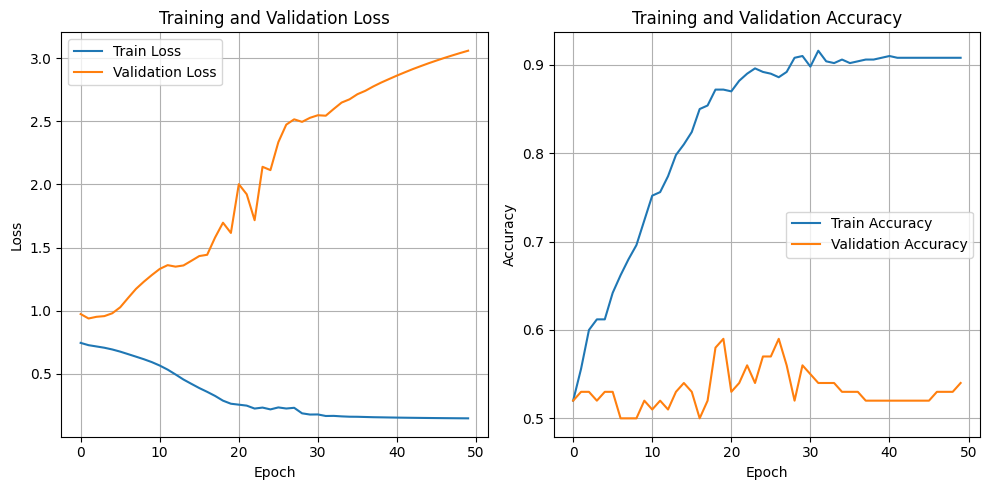

In [32]:
train_and_evaluate(
    model,
    train_sentences,
    train_lengths,
    train_labels,
    val_sentences,
    val_lengths,
    val_labels,
    epochs=50,
    batch_size=32
)

We can see that the training loss decreases steadily while the validation loss increases, indicating a clear divergence that confirms overfitting as we aimed for in the task.

The training accuracy rises demonstrating the model's ability to learn the small effectively, while the validation accuracy fluctuate while remaining significantly lower and aligning with the expectation of poor generalization due to overfitting. This showcasing that the model can learn and memorize the training data.